# *Data Prep*

In [ ]:
!pip install yfinance pandas

In [2]:
import yfinance as yf
import pandas as pd
import datetime

In [3]:
# Define the ticker symbols for Apple and Nvidia
tickers = ['AAPL', 'NVDA']

# Define the date range for 15 years
start_date = '2010-02-01'
end_date = '2025-02-01'

In [4]:
# Download historical data for both tickers
data = yf.download(tickers, start=start_date, end=end_date, interval='1d')

# The data will be a multi-index DataFrame with the columns separated by ticker
print(data.head())

[*********************100%***********************]  2 of 2 completed

Price          Close                High                 Low            \
Ticker          AAPL      NVDA      AAPL      NVDA      AAPL      NVDA   
Date                                                                     
2010-02-01  5.866568  0.379902  5.904829  0.380590  5.763234  0.351244   
2010-02-02  5.900614  0.383800  5.914472  0.388615  5.825900  0.377381   
2010-02-03  6.002139  0.387010  6.031362  0.388615  5.857230  0.378527   
2010-02-04  5.785830  0.364541  5.976231  0.383571  5.771369  0.360414   
2010-02-05  5.888563  0.371878  5.904831  0.372795  5.749679  0.357663   

Price           Open               Volume             
Ticker          AAPL      NVDA       AAPL       NVDA  
Date                                                  
2010-02-01  5.795469  0.354224  749876400  949832000  
2010-02-02  5.902121  0.378527  698342400  849812000  
2010-02-03  5.879825  0.380361  615328000  562296000  
2010-02-04  5.926823  0.383571  757652000  783480000  
2010-02-05  5.803305  

In [5]:
fundamentals = pd.DataFrame()

for ticker in tickers:
    ticker_obj = yf.Ticker(ticker)
    info = ticker_obj.info

    # Instead of append, use concat to add a new row
    fundamentals = pd.concat([fundamentals, pd.DataFrame([{
        'Ticker': ticker,
        'PE Ratio': info.get('trailingPE'),
        'Forward PE': info.get('forwardPE'),
        'PB Ratio': info.get('priceToBook'),
        'PEG Ratio': info.get('pegRatio'),
        'Beta': info.get('beta'),
        'Debt/Equity': info.get('debtToEquity'),
        'ROE': info.get('returnOnEquity'),
        'Profit Margin': info.get('profitMargins'),
        'Revenue Growth': info.get('revenueGrowth'),
        'Market Cap': info.get('marketCap'),
        'Free Cash Flow': info.get('freeCashflow'),
        'Short Ratio': info.get('shortRatio'),
    }])], ignore_index=True)

print(fundamentals)

  Ticker   PE Ratio  Forward PE   PB Ratio PEG Ratio   Beta  Debt/Equity  \
0   AAPL  37.460316   28.483185  62.649323      None  1.240      209.059   
1   NVDA  47.458500   27.001379  68.847480      None  1.657       17.221   

       ROE  Profit Margin  Revenue Growth     Market Cap  Free Cash Flow  \
0  1.57413        0.23971           0.061  3545215795200    110846001152   
1  1.23767        0.55041           1.224  2940514336768     33725874176   

   Short Ratio  
0         2.74  
1         1.01  


In [6]:
import pandas as pd

# 1. Compute daily returns for CLOSE prices across all tickers
returns = data['Close'].pct_change()

# 2. Compute rolling volatility (30-day std, annualized)
volatility = returns.rolling(window=30).std() * (252**0.5)

# 3. Compute rolling average volume as a liquidity proxy
liquidity = data['Volume'].rolling(window=30).mean()

# 4. Combine these metrics into a single DataFrame per Ticker
metrics_df = pd.DataFrame()

for ticker in tickers:
    # We can isolate each ticker's series from the multi-level columns
    ticker_data = pd.DataFrame({
        'Date': data.index,
        'Ticker': ticker,
        'Close': data['Close', ticker],
        'Return': returns[ticker],
        'Volatility': volatility[ticker],
        'Liquidity': liquidity[ticker]
    })

    # Concatenate per-ticker data into one DataFrame
    metrics_df = pd.concat([metrics_df, ticker_data], ignore_index=True)

# Data for first few rows
print(metrics_df.head(10))

        Date Ticker     Close    Return  Volatility  Liquidity
0 2010-02-01   AAPL  5.866568       NaN         NaN        NaN
1 2010-02-02   AAPL  5.900614  0.005803         NaN        NaN
2 2010-02-03   AAPL  6.002139  0.017206         NaN        NaN
3 2010-02-04   AAPL  5.785830 -0.036039         NaN        NaN
4 2010-02-05   AAPL  5.888563  0.017756         NaN        NaN
5 2010-02-08   AAPL  5.848191 -0.006856         NaN        NaN
6 2010-02-09   AAPL  5.910555  0.010664         NaN        NaN
7 2010-02-10   AAPL  5.878319 -0.005454         NaN        NaN
8 2010-02-11   AAPL  5.985270  0.018194         NaN        NaN
9 2010-02-12   AAPL  6.036786  0.008607         NaN        NaN


In [7]:
# Example: Expand metrics_df to include fundamentals
#   - Merges each row in metrics_df with the row in fundamentals that has the same ticker
merged_df = pd.merge(metrics_df, fundamentals, on='Ticker', how='left')

print(merged_df.head())

        Date Ticker     Close    Return  Volatility  Liquidity   PE Ratio  \
0 2010-02-01   AAPL  5.866568       NaN         NaN        NaN  37.460316   
1 2010-02-02   AAPL  5.900614  0.005803         NaN        NaN  37.460316   
2 2010-02-03   AAPL  6.002139  0.017206         NaN        NaN  37.460316   
3 2010-02-04   AAPL  5.785830 -0.036039         NaN        NaN  37.460316   
4 2010-02-05   AAPL  5.888563  0.017756         NaN        NaN  37.460316   

   Forward PE   PB Ratio PEG Ratio  Beta  Debt/Equity      ROE  Profit Margin  \
0   28.483185  62.649323      None  1.24      209.059  1.57413        0.23971   
1   28.483185  62.649323      None  1.24      209.059  1.57413        0.23971   
2   28.483185  62.649323      None  1.24      209.059  1.57413        0.23971   
3   28.483185  62.649323      None  1.24      209.059  1.57413        0.23971   
4   28.483185  62.649323      None  1.24      209.059  1.57413        0.23971   

   Revenue Growth     Market Cap  Free Cash Flow  

# *Correction Labeling*

In [8]:
def label_events_local_peaks(
    df,
    local_max_window=60,        # lookback window for local max (days)
    correction_threshold=0.10,  # 10% drop => correction
    crash_threshold=0.20        # 20% drop => crash
):
    """
    Flags correction/crash events by comparing today's Close
    to the highest Close in the last 'local_max_window' days.

    For each Ticker:
      - Sort the data by Date.
      - Calculate local_max = rolling max over the last 'local_max_window' days.
      - Compute drop_pct = (local_max - Close) / local_max.
      - Decide day-by-day if it's a Correction (>=10% but <20%) or Crash (>=20%).

    Once in Correction, we remain so if drop_pct stays >=10%.
    If it hits >=20%, we mark Crash. If drop_pct <10%, the event ends.
    Similarly for Crash: if drop_pct <20% but still >=10%, we can either
    downgrade to Correction or remain in Crash until full <10% recovery.

    Columns Added:
      - 'LocalMax'
      - 'DropPct'
      - 'IsCorrection'
      - 'IsCrash'
    """
    # 1. Sort
    df = df.sort_values(by=['Ticker', 'Date']).reset_index(drop=True)

    # 2. Compute a rolling local max (lookback = local_max_window)
    # We'll group by Ticker, then for each date, the local max is the maximum
    # of the last 'local_max_window' closes up to (and including) that day.
    def rolling_local_max(series, window):
        # A rolling max from the past 'window' days (including current)
        return series.rolling(window=window, min_periods=1).max()

    df['LocalMax'] = (
        df.groupby('Ticker')['Close']
          .transform(lambda x: rolling_local_max(x, local_max_window))
    )

    # 3. Initialize event flags
    df['IsCorrection'] = False
    df['IsCrash'] = False

    # We'll track a "state" for each Ticker
    # (No Event, Correction, or Crash).
    # local_max_val might shift daily as the rolling max changes.

    for ticker, group in df.groupby('Ticker', as_index=False):
        indices = group.index
        current_state = "NoEvent"  # can be "NoEvent", "Correction", "Crash"

        for i in indices:
            row = df.loc[i]
            lm = row['LocalMax']

            # 4. Compute drop_pct
            if lm > 0:
                drop_pct = (lm - row['Close']) / lm
            else:
                drop_pct = 0.0

            # Store drop_pct for reference
            df.at[i, 'DropPct'] = drop_pct

            # 5. State machine logic
            if current_state == "NoEvent":
                # If not in an event, check if we just triggered correction or crash
                if drop_pct >= crash_threshold:
                    current_state = "Crash"
                    df.at[i, 'IsCrash'] = True
                elif drop_pct >= correction_threshold:
                    current_state = "Correction"
                    df.at[i, 'IsCorrection'] = True
                # else remain NoEvent

            elif current_state == "Correction":
                if drop_pct < correction_threshold:
                    # Price recovered => end correction
                    current_state = "NoEvent"
                elif drop_pct >= crash_threshold:
                    # Deepen to crash
                    current_state = "Crash"
                    df.at[i, 'IsCrash'] = True
                else:
                    # Stay in Correction
                    df.at[i, 'IsCorrection'] = True

            elif current_state == "Crash":
                # Once in a crash, do we ever "downgrade" to Correction if 10% <= drop_pct < 20%?
                # Let's say yes, to reflect partial recovery that is still a correction.
                if drop_pct < correction_threshold:
                    # Fully recovered => no event
                    current_state = "NoEvent"
                elif drop_pct < crash_threshold and drop_pct >= correction_threshold:
                    # partial recovery => move to correction
                    current_state = "Correction"
                    df.at[i, 'IsCorrection'] = True
                else:
                    # drop_pct still >= 20% => remain Crash
                    df.at[i, 'IsCrash'] = True

    return df

Now we are going to check whether or not our current logic works, and use the following code to help tweak the logic

In [9]:
# Example usage:
labeled_df = label_events_local_peaks(
    merged_df,
    local_max_window=60,  # or 30, or 90, depending on how "local" you want it
    correction_threshold=0.10,
    crash_threshold=0.20
)

# Let's see how many days are labeled corrections/crashes
total_corrections = labeled_df['IsCorrection'].sum()
total_crashes = labeled_df['IsCrash'].sum()
print("Total correction days:", total_corrections)
print("Total crash days:", total_crashes)

# Per ticker breakdown
print("\nCorrections per Ticker:")
print(labeled_df.groupby('Ticker')['IsCorrection'].sum())

print("\nCrashes per Ticker:")
print(labeled_df.groupby('Ticker')['IsCrash'].sum())

# Spot-check January 2025 for Apple
apple_jan25 = labeled_df[
    (labeled_df['Ticker'] == 'AAPL') &
    (labeled_df['Date'] >= '2025-01-01') &
    (labeled_df['Date'] <= '2025-01-31')
]
print("\nApple in January 2025:")
print(apple_jan25[['Date','Close','LocalMax','DropPct','IsCorrection','IsCrash']])

# Same for Nvidia
nvda_jan25 = labeled_df[
    (labeled_df['Ticker'] == 'NVDA') &
    (labeled_df['Date'] >= '2025-01-01') &
    (labeled_df['Date'] <= '2025-01-31')
]
print("\nNvidia in January 2025:")
print(nvda_jan25[['Date','Close','LocalMax','DropPct','IsCorrection','IsCrash']])

Total correction days: 1249
Total crash days: 707

Corrections per Ticker:
Ticker
AAPL    640
NVDA    609
Name: IsCorrection, dtype: int64

Crashes per Ticker:
Ticker
AAPL    183
NVDA    524
Name: IsCrash, dtype: int64

Apple in January 2025:
           Date       Close    LocalMax   DropPct  IsCorrection  IsCrash
3755 2025-01-02  243.850006  259.019989  0.058567         False    False
3756 2025-01-03  243.360001  259.019989  0.060459         False    False
3757 2025-01-06  245.000000  259.019989  0.054127         False    False
3758 2025-01-07  242.210007  259.019989  0.064898         False    False
3759 2025-01-08  242.699997  259.019989  0.063007         False    False
3760 2025-01-10  236.850006  259.019989  0.085592         False    False
3761 2025-01-13  234.399994  259.019989  0.095051         False    False
3762 2025-01-14  233.279999  259.019989  0.099375         False    False
3763 2025-01-15  237.869995  259.019989  0.081654         False    False
3764 2025-01-16  228.259995

In [10]:
# Look at flagged corrections in detail
flagged_dates = labeled_df[labeled_df['IsCorrection'] == True].copy()
print("\nAll flagged correction rows:")
print(flagged_dates[['Date', 'Ticker', 'Close', 'Return', 'IsCorrection']])


All flagged correction rows:
           Date Ticker       Close    Return  IsCorrection
67   2010-05-07   AAPL    7.105679 -0.042193          True
76   2010-05-20   AAPL    7.162921 -0.042603          True
77   2010-05-21   AAPL    7.300298  0.019179          True
89   2010-06-09   AAPL    7.326806 -0.024586          True
116  2010-07-19   AAPL    7.398514 -0.017287          True
...         ...    ...         ...       ...           ...
7539 2025-01-16   NVDA  133.570007 -0.019598          True
7546 2025-01-28   NVDA  128.990005  0.089259          True
7547 2025-01-29   NVDA  123.699997 -0.041011          True
7548 2025-01-30   NVDA  124.650002  0.007680          True
7549 2025-01-31   NVDA  120.070000 -0.036743          True

[1249 rows x 5 columns]


In [11]:
apple_jan_2025 = labeled_df[
    (labeled_df['Ticker'] == 'AAPL') &
    (labeled_df['Date'] >= '2025-01-01') &
    (labeled_df['Date'] <= '2025-01-31')
].copy()

print("\nApple Rows in January 2025:")
print(apple_jan_2025[['Date', 'Close', 'Return', 'IsCorrection']])

# Print only the days flagged as corrections
apple_jan_corrections = apple_jan_2025[apple_jan_2025['IsCorrection'] == True]
print("\nApple Correction Days in January 2025:")
print(apple_jan_corrections[['Date', 'Close', 'Return', 'IsCorrection']])


Apple Rows in January 2025:
           Date       Close    Return  IsCorrection
3755 2025-01-02  243.850006 -0.026236         False
3756 2025-01-03  243.360001 -0.002009         False
3757 2025-01-06  245.000000  0.006739         False
3758 2025-01-07  242.210007 -0.011388         False
3759 2025-01-08  242.699997  0.002023         False
3760 2025-01-10  236.850006 -0.024104         False
3761 2025-01-13  234.399994 -0.010344         False
3762 2025-01-14  233.279999 -0.004778         False
3763 2025-01-15  237.869995  0.019676         False
3764 2025-01-16  228.259995 -0.040400          True
3765 2025-01-17  229.979996  0.007535          True
3766 2025-01-21  222.639999 -0.031916          True
3767 2025-01-22  223.830002  0.005345          True
3768 2025-01-23  223.660004 -0.000759          True
3769 2025-01-24  222.779999 -0.003935          True
3770 2025-01-27  229.860001  0.031780          True
3771 2025-01-28  238.259995  0.036544         False
3772 2025-01-29  239.360001  0.0046

In [12]:
nvda_jan_2025 = labeled_df[
    (labeled_df['Ticker'] == 'NVDA') &
    (labeled_df['Date'] >= '2025-01-01') &
    (labeled_df['Date'] <= '2025-01-31')
].copy()

print("\nNvidia Rows in January 2025:")
print(nvda_jan_2025[['Date', 'Close', 'Return', 'IsCorrection']])

# Print only the days flagged as corrections
nvda_jan_corrections = nvda_jan_2025[nvda_jan_2025['IsCorrection'] == True]
print("\nNvidia Correction Days in January 2025:")
print(nvda_jan_corrections[['Date', 'Close', 'Return', 'IsCorrection']])


Nvidia Rows in January 2025:
           Date       Close    Return  IsCorrection
7530 2025-01-02  138.309998  0.029935         False
7531 2025-01-03  144.470001  0.044538         False
7532 2025-01-06  149.429993  0.034332         False
7533 2025-01-07  140.139999 -0.062170         False
7534 2025-01-08  140.110001 -0.000214         False
7535 2025-01-10  135.910004 -0.029976         False
7536 2025-01-13  133.229996 -0.019719          True
7537 2025-01-14  131.759995 -0.011034          True
7538 2025-01-15  136.240005  0.034001         False
7539 2025-01-16  133.570007 -0.019598          True
7540 2025-01-17  137.710007  0.030995         False
7541 2025-01-21  140.830002  0.022656         False
7542 2025-01-22  147.070007  0.044309         False
7543 2025-01-23  147.220001  0.001020         False
7544 2025-01-24  142.619995 -0.031246         False
7545 2025-01-27  118.419998 -0.169682         False
7546 2025-01-28  128.990005  0.089259          True
7547 2025-01-29  123.699997 -0.041

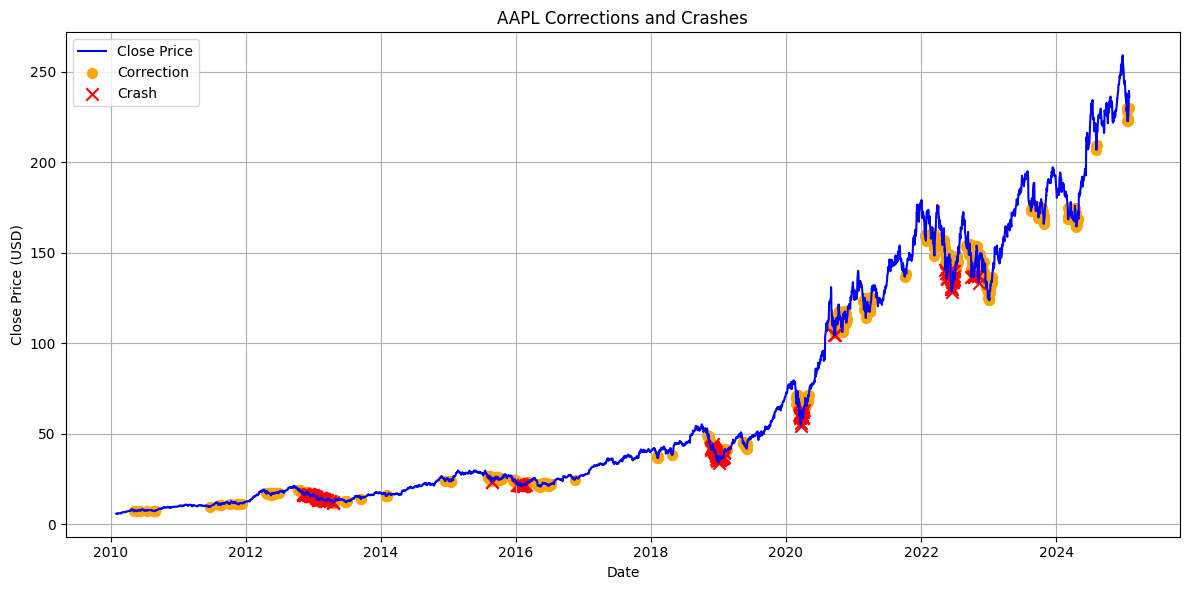

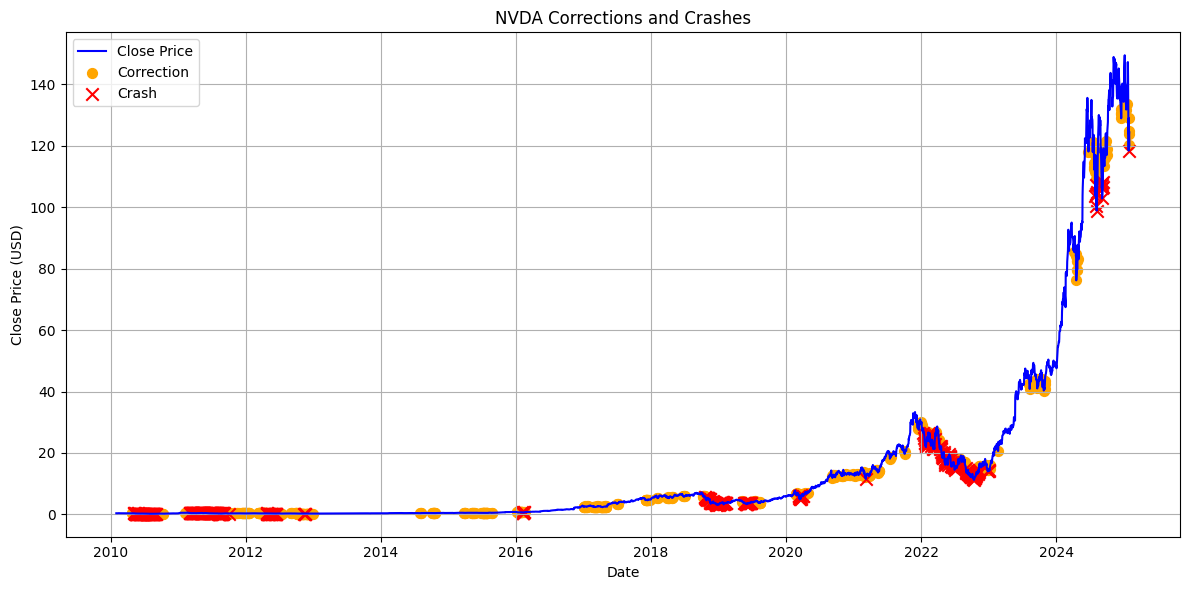

In [13]:
import matplotlib.pyplot as plt

def plot_correction_chart(df, ticker):
    # Filter the DataFrame for the given ticker
    ticker_df = df[df['Ticker'] == ticker].copy()

    # Ensure Date is in datetime format
    ticker_df['Date'] = pd.to_datetime(ticker_df['Date'])

    # Create a plot with appropriate size
    plt.figure(figsize=(12,6))

    # Plot the closing price over time
    plt.plot(ticker_df['Date'], ticker_df['Close'], label='Close Price', color='blue', linewidth=1.5)

    # Mark correction points (10% <= drop_pct < 20%)
    correction_points = ticker_df[ticker_df['IsCorrection']]
    plt.scatter(correction_points['Date'], correction_points['Close'],
                color='orange', marker='o', label='Correction', s=50)

    # Mark crash points (drop_pct >= 20%)
    crash_points = ticker_df[ticker_df['IsCrash']]
    plt.scatter(crash_points['Date'], crash_points['Close'],
                color='red', marker='x', label='Crash', s=80)

    # Customize the plot
    plt.title(f"{ticker} Corrections and Crashes")
    plt.xlabel("Date")
    plt.ylabel("Close Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Generate charts for both Apple and Nvidia
plot_correction_chart(labeled_df, "AAPL")
plot_correction_chart(labeled_df, "NVDA")

# *TDA Implementation*

In [14]:
import numpy as np

def takens_embedding(series, embedding_dim=2, time_delay=1):
    """
    Given a 1D array-like 'series', produce a time-delay embedding in 'embedding_dim' dimensions,
    with a lag of 'time_delay'.
    Returns an array of shape (num_points, embedding_dim).
    """
    arr = np.asarray(series, dtype=float)
    n = len(arr)
    # The last valid start for a full embedding:
    # e.g., if embedding_dim=2, time_delay=1, you need at least 2 data points
    max_start = n - (embedding_dim - 1) * time_delay
    if max_start < 1:
        # Not enough data for even 1 embedding vector
        return np.array([])

    embedded_points = []
    for start_idx in range(max_start):
        coords = [arr[start_idx + j*time_delay] for j in range(embedding_dim)]
        embedded_points.append(coords)
    return np.array(embedded_points)

In [16]:
!pip install gudhi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 23.8 MB/s eta 0:00:00


In [17]:
import gudhi

def compute_persistence_intervals(point_cloud, max_dim=1, max_edge_length=None):
    """
    Build a RipsComplex in GUDHI, create a SimplexTree,
    and return the intervals for each dimension in a dict {dim: array_of_[birth, death]}.
    """
    # 1. Create the RipsComplex
    if max_edge_length is None:
        rips_complex = gudhi.RipsComplex(points=point_cloud)
    else:
        rips_complex = gudhi.RipsComplex(points=point_cloud, max_edge_length=max_edge_length)

    # 2. Build the simplex tree and compute persistence
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dim)
    simplex_tree.persistence()

    # 3. Collect intervals by dimension
    intervals = {}
    for dim in range(max_dim + 1):
        intervals[dim] = simplex_tree.persistence_intervals_in_dimension(dim)
    return intervals

In [18]:
def betti_curve(intervals, num_samples=50):
    """
    Convert intervals {dim: array([[birth, death], ...])} into
    Betti curves for each dimension.
    Returns a dict {dim: (radii, betti_vals)}.
    """
    # Replace infinite death values with a large finite number.
    for dim, intvls in intervals.items():
        if len(intvls) > 0:
            # Replace any infinite values (typically in the death column) with 1e9.
            intvls[np.isinf(intvls)] = 1e4
            intervals[dim] = intvls  # update back in the dictionary

    all_bd = []
    for dim, intvls in intervals.items():
        if len(intvls) > 0:
            all_bd.extend(intvls.flatten())

    if len(all_bd) == 0:
        return {}

    min_r = float(np.min(all_bd))
    max_r = float(np.max(all_bd))
    if max_r == min_r:
        max_r = min_r + 1e-6  # just to avoid zero-range

    radii = np.linspace(min_r, max_r, num_samples)
    curves = {}

    for dim, intvls in intervals.items():
        betti_vals = []
        for r in radii:
            # Count how many intervals are "alive" at radius r
            alive = np.sum((intvls[:, 0] <= r) & (r < intvls[:, 1]))
            betti_vals.append(alive)
        curves[dim] = (radii, np.array(betti_vals, dtype=float))

    return curves

In [19]:
def summarize_betti_curves(curves):
    summary = {}
    for dim, (radii, betti_vals) in curves.items():
        if dim == 0:
            adjusted_vals = np.clip(betti_vals - 1, 0, None)
            area_val = float(np.trapz(adjusted_vals, radii))
            max_val = float(adjusted_vals.max())
        else:
            area_val = float(np.trapz(betti_vals, radii))
            max_val = float(betti_vals.max())
        summary[f'Betti{dim}_Area'] = area_val
        summary[f'Betti{dim}_Max'] = max_val
    return summary

In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
def compute_tda_features(
    df,
    ticker_col='Ticker',
    date_col='Date',
    value_col='Return',
    window_size=30,
    embedding_dim=2,
    time_delay=1,
    max_dim=1,
    max_edge_length=None,
    n_betti_samples=50
):
    """
    Compute TDA features for each (Ticker, window) and store them on the window's end day.
    Returns a new DataFrame with columns like Betti0_Area, Betti0_Max, Betti1_Area, Betti1_Max, etc.
    Now, with an added normalization step on each window's data.
    """
    # 1) Sort input
    df = df.sort_values([ticker_col, date_col]).reset_index(drop=True)

    # We'll accumulate final results here
    output_dfs = []

    # Process each Ticker separately
    for ticker, grp in df.groupby(ticker_col):
        grp = grp.sort_values(date_col).reset_index(drop=True)
        series_values = grp[value_col].values

        # This will hold a dictionary of TDA features for each row (most rows = None, except end-of-window rows)
        tda_list = [None] * len(grp)

        # Slide a window over the series
        for start_idx in range(len(series_values) - window_size + 1):
            end_idx = start_idx + window_size
            window_data = series_values[start_idx:end_idx]

            # **Normalization Step:**
            # Reshape data to 2D and apply StandardScaler
            scaler = StandardScaler()
            window_data_scaled = scaler.fit_transform(window_data.reshape(-1, 1)).ravel()

            # 3a) Takens Embedding on normalized data
            point_cloud = takens_embedding(window_data_scaled, embedding_dim, time_delay)
            if point_cloud.shape[0] < 2:
                continue  # Not enough points to form a complex

            # 3b) Compute Persistence Intervals
            intervals = compute_persistence_intervals(
                point_cloud,
                max_dim=max_dim,
                max_edge_length=max_edge_length
            )

            # 3c) Compute Betti Curves
            curves = betti_curve(intervals, num_samples=n_betti_samples)

            # 3d) Summarize the Betti Curves into a flat dictionary
            summary_dict = summarize_betti_curves(curves)

            # Attach the summary to the last row in the window
            tda_list[end_idx - 1] = summary_dict

        # Convert list of dicts to a DataFrame
        tda_features_df = pd.DataFrame(tda_list)

        # Merge with the original group data
        grp_out = pd.concat([grp, tda_features_df], axis=1)
        output_dfs.append(grp_out)

    # Combine all ticker groups
    final_df = pd.concat(output_dfs, ignore_index=True)
    return final_df

In [22]:
# Fill NaNs and create LogClose column
labeled_df['Return'] = labeled_df['Return'].fillna(0)
labeled_df['LogClose'] = np.log(labeled_df['Close'])

# Compute TDA features using the LogClose column
tda_enriched_df = compute_tda_features(
    df=labeled_df,
    ticker_col='Ticker',
    date_col='Date',
    value_col='LogClose',   # use only one value column here
    window_size=20,         # typical TDA window length
    embedding_dim=3,        # try a higher embedding dimension
    time_delay=2,
    max_dim=1,              # compute up to H1
    max_edge_length=None,   # no explicit limit
    n_betti_samples=50
)

# If there's a column named 0 (holding the TDA dictionary), expand it:
if 0 in tda_enriched_df.columns:
    tda_features_df = pd.json_normalize(tda_enriched_df[0])
    tda_enriched_df = tda_enriched_df.drop(columns=[0])
    tda_enriched_df = tda_enriched_df.join(tda_features_df)

# Inspect new columns and first 60 rows
print(tda_enriched_df.columns)
# First rows will have NaN values until enough time accumulates to generate data
tda_enriched_df.head(60)

Index(['Date', 'Ticker', 'Close', 'Return', 'Volatility', 'Liquidity',
       'PE Ratio', 'Forward PE', 'PB Ratio', 'PEG Ratio', 'Beta',
       'Debt/Equity', 'ROE', 'Profit Margin', 'Revenue Growth', 'Market Cap',
       'Free Cash Flow', 'Short Ratio', 'LocalMax', 'IsCorrection', 'IsCrash',
       'DropPct', 'LogClose', 'Betti0_Area', 'Betti0_Max', 'Betti1_Area',
       'Betti1_Max'],
      dtype='object')


,Date,Ticker,Close,Return,Volatility,Liquidity,PE Ratio,Forward PE,PB Ratio,PEG Ratio,...,Short Ratio,LocalMax,IsCorrection,IsCrash,DropPct,LogClose,Betti0_Area,Betti0_Max,Betti1_Area,Betti1_Max
0,2010-02-01,AAPL,5.866568,0.000000,NaN,NaN,37.460316,28.483185,62.649323,None,...,2.74,5.866568,False,False,0.000000,1.769270,NaN,NaN,NaN,NaN
1,2010-02-02,AAPL,5.900614,0.005803,NaN,NaN,37.460316,28.483185,62.649323,None,...,2.74,5.900614,False,False,0.000000,1.775056,NaN,NaN,NaN,NaN
2,2010-02-03,AAPL,6.002139,0.017206,NaN,NaN,37.460316,28.483185,62.649323,None,...,2.74,6.002139,False,False,0.000000,1.792116,NaN,NaN,NaN,NaN
3,2010-02-04,AAPL,5.785830,-0.036039,NaN,NaN,37.460316,28.483185,62.649323,None,...,2.74,6.002139,False,False,0.036039,1.755412,NaN,NaN,NaN,NaN
4,2010-02-05,AAPL,5.888563,0.017756,NaN,NaN,37.460316,28.483185,62.649323,None,...,2.74,6.002139,False,False,0.018923,1.773012,NaN,NaN,NaN,NaN
5,2010-02-08,AAPL,5.848191,-0.006856,NaN,NaN,37.460316,28.483185,62.649323,None,...,2.74,6.002139,False,False,0.025649,1.766132,NaN,NaN,NaN,NaN
6,2010-02-09,AAPL,5.910555,0.010664,NaN,NaN,37.460316,28.483185,62.649323,None,...,2.74,6.002139,False,False,0.015259,1.776740,NaN,NaN,NaN,NaN
7,2010-02-10,AAPL,5.878319,-0.005454,NaN,NaN,37.460316,28.483185,62.649323,None,...,2.74,6.002139,False,False,0.020629,1.771271,NaN,NaN,NaN,NaN
8,2010-02-11,AAPL,5.985270,0.018194,NaN,NaN,37.460316,28.483185,62.649323,None,...,2.74,6.002139,False,False,0.002811,1.789301,NaN,NaN,NaN,NaN
9,2010-02-12,AAPL,6.036786,0.008607,NaN,NaN,37.460316,28.483185,62.649323,None,...,2.74,6.036786,False,False,0.000000,1.797872,NaN,NaN,NaN,NaN


# *ML Classifier Modeling*

In [23]:
###########################
# 1) Imports and Setup
###########################
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

###########################
# 2) Prepare Data
###########################

# Create a label column if not already present
# Label = 1 if IsCorrection is True, else 0
tda_enriched_df['label'] = tda_enriched_df['IsCorrection'].astype(int)

# List of financial/baseline features (tweak as needed)
baseline_features = [
    'Volatility', 'Liquidity', 'PE Ratio', 'Forward PE', 'PB Ratio', 'PEG Ratio',
    'Beta', 'Debt/Equity', 'ROE', 'Profit Margin', 'Revenue Growth', 'Market Cap',
    'Free Cash Flow', 'Short Ratio'
]

# Identify TDA feature columns
tda_feature_columns = [
    col for col in tda_enriched_df.columns
    if isinstance(col, str) and 'Betti' in col
]

# Fill and infer object types to avoid warnings
X_financial = tda_enriched_df[baseline_features].fillna(0).infer_objects()
X_tda = tda_enriched_df[tda_feature_columns].fillna(0).infer_objects()

# Extract the label
y = tda_enriched_df['label']

###########################
# 3) Construct Enhanced Features
###########################

# Scale TDA features
scaler = StandardScaler()
X_tda_scaled = scaler.fit_transform(X_tda)

# Create polynomial interactions among TDA features (optional)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_tda_poly = poly.fit_transform(X_tda_scaled)

# Combine baseline + TDA features
import numpy as np
X_enhanced = np.hstack([X_financial.values, X_tda_poly])

###########################
# 4) Train-Test Split (Time-Ordered)
###########################
train_size = int(len(tda_enriched_df) * 0.8)
Xb_train = X_financial.iloc[:train_size]
Xb_test  = X_financial.iloc[train_size:]
Xe_train = X_enhanced[:train_size]
Xe_test  = X_enhanced[train_size:]
y_train  = y.iloc[:train_size]
y_test   = y.iloc[train_size:]

###########################
# 5) Train & Evaluate Models
###########################

# Baseline Model (financial features only)
clf_baseline = XGBClassifier(
    n_estimators=100,
    random_state=42,
    eval_metric='logloss'  # ignoring use_label_encoder for xgboost >1.0
)
clf_baseline.fit(Xb_train, y_train)
y_pred_baseline = clf_baseline.predict(Xb_test)

# Enhanced Model (financial + TDA features)
clf_enhanced = XGBClassifier(
    n_estimators=100,
    random_state=42,
    eval_metric='logloss'
)
clf_enhanced.fit(Xe_train, y_train)
y_pred_enhanced = clf_enhanced.predict(Xe_test)

###########################
# 6) Compare Metrics
###########################

print("==== Baseline Model ====")
base_acc = accuracy_score(y_test, y_pred_baseline)
print(f"Accuracy : {base_acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_baseline))

print("\n==== Enhanced Model ====")
enh_acc = accuracy_score(y_test, y_pred_enhanced)
print(f"Accuracy : {enh_acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_enhanced))

<ipython-input-23-7ae32dbc626e>:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_financial = tda_enriched_df[baseline_features].fillna(0).infer_objects()


==== Baseline Model ====
Accuracy : 0.7662
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.87      1243
           1       0.18      0.09      0.12       267

    accuracy                           0.77      1510
   macro avg       0.50      0.50      0.49      1510
weighted avg       0.71      0.77      0.73      1510


==== Enhanced Model ====
Accuracy : 0.7662
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.87      1243
           1       0.18      0.09      0.12       267

    accuracy                           0.77      1510
   macro avg       0.50      0.50      0.49      1510
weighted avg       0.71      0.77      0.73      1510



In [24]:
# Filter Apple rows
apple_df = labeled_df[labeled_df['Ticker'] == 'AAPL'].copy()
apple_df.to_csv('apple_data.csv', index=False)

# Filter Nvidia rows
nvidia_df = labeled_df[labeled_df['Ticker'] == 'NVDA'].copy()
nvidia_df.to_csv('nvidia_data.csv', index=False)

print("Apple data saved to apple_data.csv")
print("Nvidia data saved to nvidia_data.csv")


Apple data saved to apple_data.csv
Nvidia data saved to nvidia_data.csv
